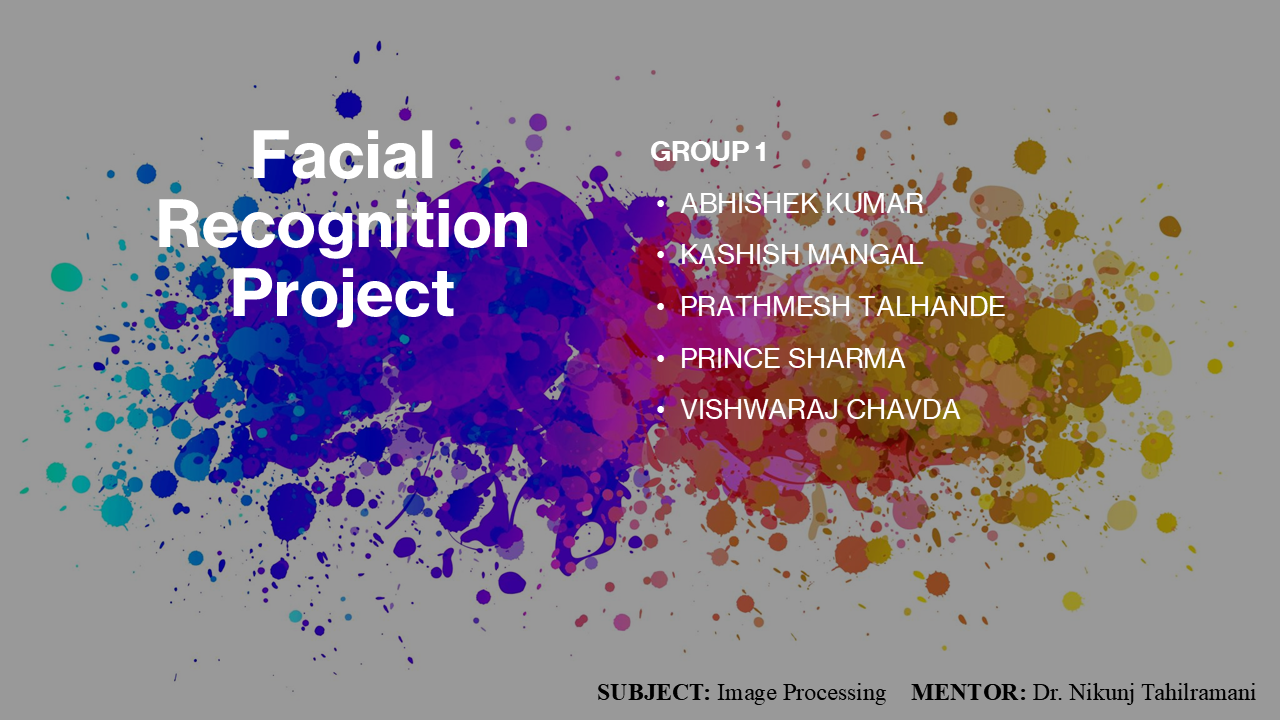

## **Introduction**

- In this project, we focus on face recognition using the Labeled Faces in the Wild (LFW) dataset, which contains a variety of images featuring different individuals. Our goal is to classify these faces accurately using machine learning techniques.
- To begin, we train a Support Vector Classifier (SVC) model on the LFW dataset. SVC is a powerful algorithm known for its effectiveness in high-dimensional spaces, making it suitable for image classification tasks.
- To enhance the performance of our model, particularly in terms of recall, a crucial metric for identifying individuals correctly, we implement a stacking ensemble method. This approach combines multiple classifiers to leverage their strengths and improve overall accuracy.
- Before training our models, we extract principal components from the images using Principal Component Analysis (PCA). This dimensionality reduction technique helps simplify the data while preserving essential features, making it easier for the classifiers to learn and perform well.
- Through this structured approach, we aim to achieve better face classification results, ultimately contributing to advancements in face recognition technologies.

## **About Data**

The Labeled Faces in the Wild (LFW) dataset is a collection of face photographs designed for studying the problem of unconstrained face recognition. It is a challenging dataset because it contains a wide variety of images with different poses, expressions, lighting conditions, and image quality.

---
Key characteristics of the LFW dataset:

1.   Large number of images: It contains more than 13,000 images of faces collected from the web.
2.   Multiple people: The dataset includes images of more than 5,700 different people.

1.   Unconstrained conditions: The images are taken under a variety of conditions, including different lighting, poses, and expressions.

1.   Labeled data: Each image is labeled with the identity of the person shown in it.

---

Uses of the LFW dataset: The LFW dataset is commonly used for evaluating the performance of face recognition algorithms. It is a benchmark dataset for researchers to compare their models and techniques. It is also used for training and evaluating machine learning models for face recognition, such as Support Vector Machines (SVMs) or deep learning models.

The LFW dataset has played an important role in the advancement of face recognition research and technology. It has helped researchers develop more robust and accurate algorithms that can perform well in challenging real-world scenarios.

Link: https://vis-www.cs.umass.edu/lfw/





## **Code**

**1. Importing necessary libraries**

In [1]:
from time import time

import matplotlib.pyplot as plt
from scipy.stats import loguniform

from sklearn.datasets import fetch_lfw_people
from sklearn.decomposition import PCA
from sklearn.metrics import ConfusionMatrixDisplay, classification_report
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC

**Observations:**

1. **time**: Measures execution duration for performance evaluation.

2. **matplotlib.pyplot**: Creates visualizations, such as confusion matrices.

3. **scipy.stats.loguniform**: Samples values from a log-uniform distribution for hyperparameter tuning.

4. **sklearn.datasets.fetch_lfw_people**: Loads the Labeled Faces in the Wild (LFW) dataset for face recognition.

5. **sklearn.decomposition.PCA**: Reduces dimensionality of data while preserving variance.

6. **sklearn.metrics.ConfusionMatrixDisplay**: Visualizes confusion matrices to assess classification performance.

7. **sklearn.metrics.classification_report**: Generates detailed performance metrics (precision, recall, F1-score).

8. **sklearn.model_selection.RandomizedSearchCV**: Tunes hyperparameters by randomly sampling combinations.

9. **sklearn.model_selection.train_test_split**: Splits data into training and testing sets for reliable evaluation.

10. **sklearn.preprocessing.StandardScaler**: Standardizes features by removing the mean and scaling to unit variance.

11. **sklearn.svm.SVC**: Support Vector Classifier used for high-dimensional classification tasks like face recognition.

**2. Load the data**

In [21]:
lfw_people = fetch_lfw_people(min_faces_per_person=70, resize=0.4)

# introspect the images arrays to find the shapes (for plotting)
n_samples, h, w = lfw_people.images.shape

# for machine learning we use the 2 data directly (as relative pixel positions info is ignored by this model)
X = lfw_people.data
n_features = X.shape[1]

# the label to predict is the id of the person
y = lfw_people.target
target_names = lfw_people.target_names
n_classes = target_names.shape[0]

print("Total dataset size:")
print("n_samples: %d" % n_samples)
print("n_features: %d" % n_features)
print("n_classes: %d" % n_classes)

Total dataset size:
n_samples: 1288
n_features: 1850
n_classes: 7


**Observations:**

  - The loaded data contains a total of 1,288 samples, each with 1,850 features. It is categorized into 7 distinct classes.

**2.1 Sample pictures from lfw dataset**

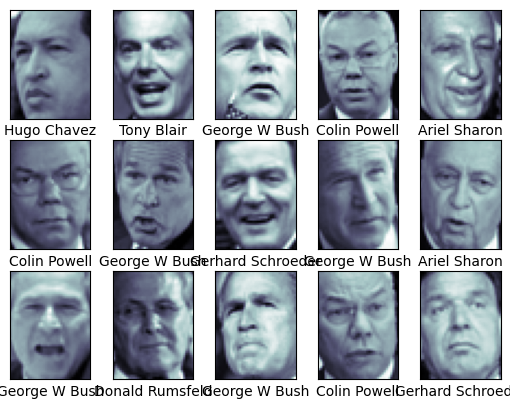

In [3]:
fig, ax = plt.subplots(3, 5)
for i, axi in enumerate(ax.flat):
    axi.imshow(lfw_people.images[i], cmap='bone')
    axi.set(xticks=[], yticks=[],
            xlabel=lfw_people.target_names[lfw_people.target[i]])
plt.show()

**2.2 Class Distribution**

In [4]:
n_photos_per_person = {}
for person_id in lfw_people.target:
  person_name = lfw_people.target_names[person_id]
  if person_name not in n_photos_per_person:
    n_photos_per_person[person_name] = 0
  n_photos_per_person[person_name] += 1

for person_name, n_photos in n_photos_per_person.items():
  print(f"{person_name}: {n_photos} photos")

Hugo Chavez: 71 photos
Tony Blair: 144 photos
George W Bush: 530 photos
Colin Powell: 236 photos
Ariel Sharon: 77 photos
Gerhard Schroeder: 109 photos
Donald Rumsfeld: 121 photos


**Observations:**

  - George W Bush is the majority class & Hugo Chavez and Ariel Sharon are the minority class. It shows class imbalance.

**2.3 Image Dimensions**

In [5]:
print(f"Image dimensions: {h} x {w}")

Image dimensions: 50 x 37


**Observations:**

- Resolution of 50 pixels wide by 37 pixels high.

**Aspect ratio**

In [6]:
aspect_ratio = w / h
print(f"Aspect ratio: {w}:{h}")

Aspect ratio: 37:50


**Observations:**

  - The aspect ratio is the proportional relationship between the width and height of an image.

**3. Split into a training set and a test**

In [7]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42
)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

**4. Compute a PCA (eigenfaces) on the face dataset (treated as unlabeled dataset): unsupervised feature extraction / dimensionality reduction**

In [8]:
n_components = 150

print(
    "Extracting the top %d eigenfaces from %d faces" % (n_components, X_train.shape[0])
)
t0 = time()
pca = PCA(n_components=n_components, svd_solver="randomized", whiten=True).fit(X_train)
print("done in %0.3fs" % (time() - t0))

eigenfaces = pca.components_.reshape((n_components, h, w))

print("Projecting the input data on the eigenfaces orthonormal basis")
t0 = time()
X_train_pca = pca.transform(X_train)
X_test_pca = pca.transform(X_test)
print("done in %0.3fs" % (time() - t0))

Extracting the top 150 eigenfaces from 966 faces
done in 0.110s
Projecting the input data on the eigenfaces orthonormal basis
done in 0.008s


**Observations:**

  The code performs Principal Component Analysis (PCA) to extract the top 150 eigenfaces from the training set and reduces the dimensionality of both the training and test datasets, simplifying the data while retaining essential features for further analysis.

**5. Train a SVM classification model**

In [9]:
print("Fitting the classifier to the training set")
t0 = time()
param_grid = {
    "C": loguniform(1e3, 1e5),
    "gamma": loguniform(1e-4, 1e-1),
}
clf = RandomizedSearchCV(
    SVC(kernel="rbf", class_weight="balanced"), param_grid, n_iter=10
)
clf = clf.fit(X_train_pca, y_train)
print("done in %0.3fs" % (time() - t0))
print("Best estimator found by grid search:")
print(clf.best_estimator_)

Fitting the classifier to the training set
done in 7.143s
Best estimator found by grid search:
SVC(C=13086.36127523347, class_weight='balanced', gamma=0.0022823024929250753)


**6. Quantitative evaluation of the model quality on the test set**

Predicting people's names on the test set
done in 0.093s
                   precision    recall  f1-score   support

     Ariel Sharon       0.67      0.77      0.71        13
     Colin Powell       0.75      0.87      0.81        60
  Donald Rumsfeld       0.81      0.78      0.79        27
    George W Bush       0.89      0.93      0.91       146
Gerhard Schroeder       0.85      0.68      0.76        25
      Hugo Chavez       0.89      0.53      0.67        15
       Tony Blair       0.94      0.81      0.87        36

         accuracy                           0.85       322
        macro avg       0.83      0.77      0.79       322
     weighted avg       0.85      0.85      0.85       322



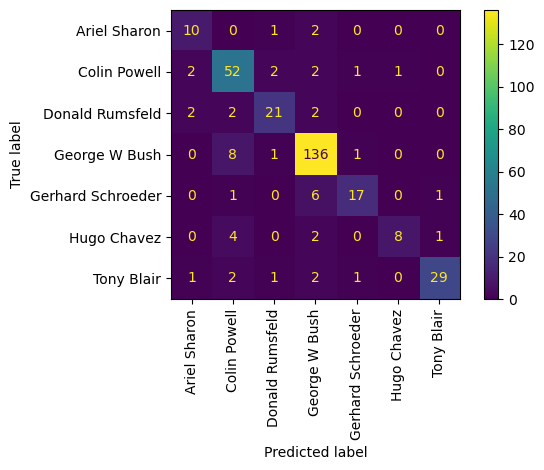

In [10]:
print("Predicting people's names on the test set")
t0 = time()
y_pred = clf.predict(X_test_pca)
print("done in %0.3fs" % (time() - t0))

print(classification_report(y_test, y_pred, target_names=target_names))
ConfusionMatrixDisplay.from_estimator(
    clf, X_test_pca, y_test, display_labels=target_names, xticks_rotation="vertical"
)
plt.tight_layout()
plt.show()

**Observations:**

  The model performs best with George W. Bush and Colin Powell, while it struggles with Hugo Chavez and Gerhard Schroeder, where recall scores suggest that many instances are being misclassified. The macro average recall of 0.77 reflects moderate overall performance, while the weighted average recall of 0.85 indicates better performance for classes with more instances

**7. Qualitative evaluation of the predictions using matplotlib**

In [11]:
def plot_gallery(images, titles, h, w, n_row=3, n_col=4):
    """Helper function to plot a gallery of portraits"""
    plt.figure(figsize=(1.8 * n_col, 2.4 * n_row))
    plt.subplots_adjust(bottom=0, left=0.01, right=0.99, top=0.90, hspace=0.35)
    for i in range(n_row * n_col):
        plt.subplot(n_row, n_col, i + 1)
        plt.imshow(images[i].reshape((h, w)), cmap=plt.cm.gray)
        plt.title(titles[i], size=12)
        plt.xticks(())
        plt.yticks(())

**8. plot the result of the prediction on a portion of the test set**

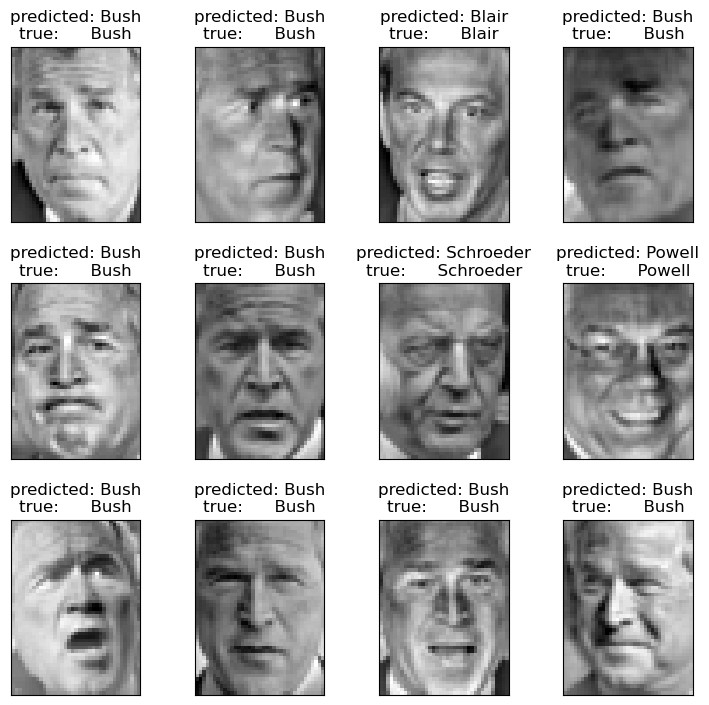

In [12]:
def title(y_pred, y_test, target_names, i):
    pred_name = target_names[y_pred[i]].rsplit(" ", 1)[-1]
    true_name = target_names[y_test[i]].rsplit(" ", 1)[-1]
    return "predicted: %s\ntrue:      %s" % (pred_name, true_name)


prediction_titles = [
    title(y_pred, y_test, target_names, i) for i in range(y_pred.shape[0])
]

plot_gallery(X_test, prediction_titles, h, w)

**9. plot the gallery of the most significative eigenfaces**

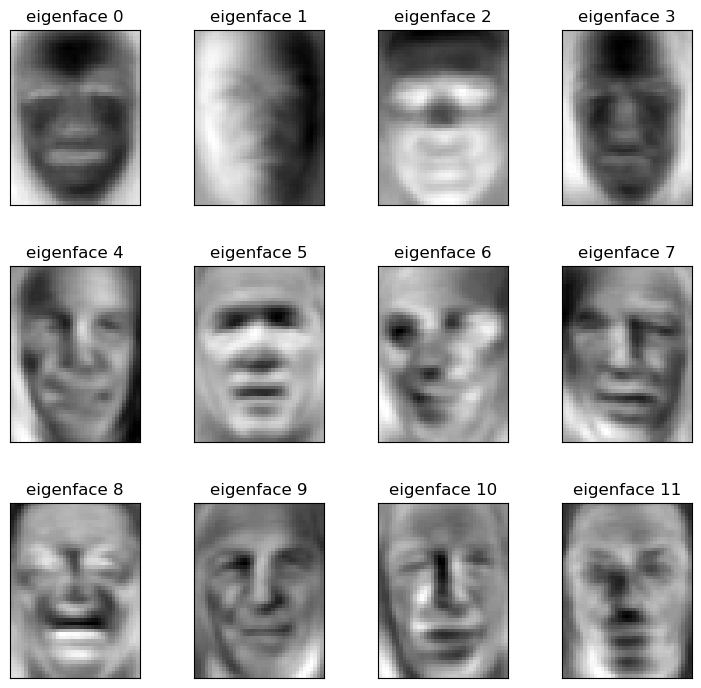

In [13]:
eigenface_titles = ["eigenface %d" % i for i in range(eigenfaces.shape[0])]
plot_gallery(eigenfaces, eigenface_titles, h, w)

plt.show()

10. **Stacked Generalization**

Training Stacking Ensemble...
done in 440.397s
Predicting people's names on the test set
done in 0.167s
                   precision    recall  f1-score   support

     Ariel Sharon       0.73      0.85      0.79        13
     Colin Powell       0.85      0.88      0.87        60
  Donald Rumsfeld       0.77      0.63      0.69        27
    George W Bush       0.93      0.97      0.95       146
Gerhard Schroeder       0.92      0.88      0.90        25
      Hugo Chavez       0.87      0.87      0.87        15
       Tony Blair       0.97      0.86      0.91        36

         accuracy                           0.90       322
        macro avg       0.86      0.85      0.85       322
     weighted avg       0.90      0.90      0.90       322



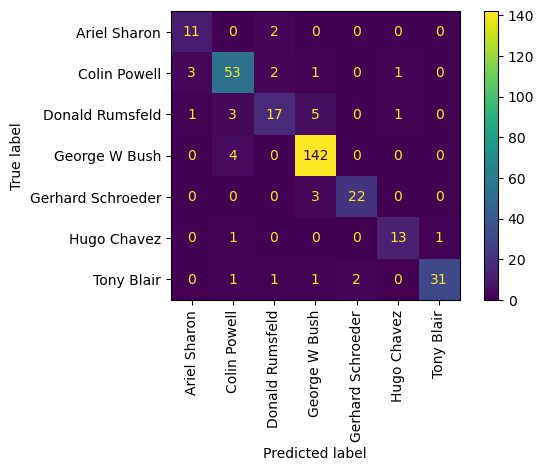

In [17]:
from sklearn.metrics import ConfusionMatrixDisplay, classification_report
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, StackingClassifier
from sklearn.linear_model import LogisticRegression

# Initialize base classifiers with fixed parameters
estimators = [
    ('svc', SVC(kernel='rbf', class_weight='balanced', probability=True)),
    ('knn', KNeighborsClassifier(n_neighbors=5)),
    ('rf', RandomForestClassifier(n_estimators=150)),
    ('gb', GradientBoostingClassifier(n_estimators=150))
]

# Train a Stacking Ensemble
print("Training Stacking Ensemble...")
t0 = time()
clf = StackingClassifier(estimators=estimators, final_estimator=LogisticRegression())
clf.fit(X_train_pca, y_train)
print("done in %0.3fs" % (time() - t0))

# Evaluate the model on the test set
print("Predicting people's names on the test set")
t0 = time()
y_pred = clf.predict(X_test_pca)
print("done in %0.3fs" % (time() - t0))

# Classification report and confusion matrix
print(classification_report(y_test, y_pred, target_names=target_names))
ConfusionMatrixDisplay.from_estimator(
    clf, X_test_pca, y_test, display_labels=target_names, xticks_rotation="vertical"
)
plt.tight_layout()
plt.show()

**Observations:**

  We enhanced the model's performance using stacked generalization, focusing on recall. The macro avg-recall score improved from .77 to .85. George W. Bush achieved the highest recall at 0.97, demonstrating excellent identification. Colin Powell followed with a recall of 0.88, while Gerhard Schroeder and Hugo Chavez had recalls of 0.88 and 0.87, respectively. However, Donald Rumsfeld had a lower recall of 0.63, indicating room for improvement in recognizing that class. 

## **Conclusion**

- In this LFW dataset classification project, we learned effective methods for handling image datasets.
- We explored dimensionality reduction techniques, particularly using PCA, alongside classifiers such as SVC, KNN, Random Forest, and Gradient Boosting.
- We demonstrated that stacking improves model performance by combining multiple classifiers.
- Various methods, including AdaBoost, GridSearch, and Random Search, were attempted for parameter tuning.
- Due to hardware limitations, we were unable to achieve the desired output, highlighting the importance of computational capacity in image processing and machine learning.
- The findings suggest that with enhanced computational resources and fine-tuning, model performance can be significantly improved.
- This project lays the groundwork for future learning and advancements in image classification techniques.